# 1. Importing Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#data preprocess
from sklearn.impute import SimpleImputer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.layers import SimpleRNN

# 2. Configuration

In [2]:
class CFG:
  data_path = './data/df.csv'
  imputer = 'median'
  max_words = 2000
  maxlen = 2
  bins = [0,10,50,100,600]
  epoch = 20

# 3. Data Preprocessing

In [3]:
# df read
df = pd.read_csv(CFG.data_path, header=0, dtype={'date_ori': str})
df = df.sort_values(by=['date_ori'])
df = df[df['item2'] == 'UPS']
df = df[df['kind'] == 's']
df = df.loc[:,['category1','category2','category3','year','month','volumn','count']]
df = df[df['count']<50]
df = df.reset_index(drop=True)

In [4]:
#volumn 결측치를 중앙값으로 대체
imputer=SimpleImputer(missing_values=np.nan,strategy=CFG.imputer)
dataimputed=imputer.fit_transform(df['volumn'].values.reshape(-1,1))
df['volumn']=dataimputed
df

,category1,category2,category3,year,month,volumn,count
0,민간기업,건축및부동산,건축,2011,1,15.0,10.0
1,민간기업,건축및부동산,건축,2011,1,30.0,1.0
2,공공기관,"공사,공단",공사,2011,1,15.0,1.0
3,정보통신,정보통신,IT기업,2011,1,10.0,1.0
4,공공기관,기관,"부,처",2011,1,15.0,1.0
...,...,...,...,...,...,...,...
4850,민간기업,제조업,기기,2020,12,50.0,1.0
4851,교육기관,교육시설,연구소,2020,12,15.0,1.0
4852,민간기업,제조업,기기,2020,12,30.0,1.0
4853,공공기관,관공서,우체국,2020,12,3.0,1.0


In [5]:
#tokenizer화를 위한 데이터 조정
cate1list=list(df['category1'])
cate2list=list(df['category2'])
joinlist=[]
for i in range(len(cate1list)):
    joinlist.append(cate1list[i]+'-'+cate2list[i])
df['join']=joinlist
df.head()

,category1,category2,category3,year,month,volumn,count,join
0,민간기업,건축및부동산,건축,2011,1,15.0,10.0,민간기업-건축및부동산
1,민간기업,건축및부동산,건축,2011,1,30.0,1.0,민간기업-건축및부동산
2,공공기관,"공사,공단",공사,2011,1,15.0,1.0,"공공기관-공사,공단"
3,정보통신,정보통신,IT기업,2011,1,10.0,1.0,정보통신-정보통신
4,공공기관,기관,"부,처",2011,1,15.0,1.0,공공기관-기관


In [6]:
#token화
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(7)
tf.random.set_seed(7)
tokenizer = Tokenizer(num_words=CFG.max_words) # 빈도가 높은 2000개의 단어를 선택하도록 객체 생성
tokenizer.fit_on_texts(joinlist) #단어 인덱스 구축

X = tokenizer.texts_to_sequences(joinlist)
print('lengths of 10 documents:', [len(doc) for doc in X[:10]])
print('num of tokens:', len(tokenizer.word_index))

lengths of 10 documents: [2, 2, 3, 2, 2, 2, 2, 2, 2, 3]
num of tokens: 22


In [7]:
 #문서의 단어 수를 제한
# 잘라낼 때, 앞을 자를 지, 뒤를 자를 지 선택할 수 있음. 뒤를 자름. post
X = pad_sequences(X, maxlen=CFG.maxlen, truncating='post') 
print(X)

[[ 4 10]
 [ 4 10]
 [ 1  5]
 ...
 [ 4  7]
 [ 1 14]
 [ 1  3]]


In [8]:
# UPS 용량 카테고리화
volumn = df.iloc[:,5].values.reshape(-1,1)# numpy로 변환
volumn = np.where(np.logical_and(volumn>=CFG.bins[0],volumn<=CFG.bins[1]), 1, volumn)
volumn = np.where(np.logical_and(volumn>CFG.bins[1],volumn<=CFG.bins[2]), 2, volumn)
volumn = np.where(np.logical_and(volumn>CFG.bins[2],volumn<=CFG.bins[3]), 3, volumn)
volumn = np.where(np.logical_and(volumn>CFG.bins[3],volumn<=CFG.bins[4]), 4, volumn)
volumn_one_hot = pd.get_dummies(volumn.reshape(-1))
num_volumn = volumn_one_hot.shape[1]
volumn_one_hot = volumn_one_hot.values.reshape(-1,num_volumn)

# 4. RNN

In [9]:
# X, Y
array_join=np.array(X).astype(np.float32)
print(array_join.shape)

(4855, 2)


In [10]:
x = array_join
y = volumn_one_hot
print(x.shape)
print(y.shape)

(4855, 2)
(4855, 4)


In [11]:
#train test dataset 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3884, 2)
(3884, 4)
(971, 2)
(971, 4)


In [12]:
%matplotlib inline
def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training and validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [13]:
#class weight
weights = class_weight.compute_class_weight('balanced', np.unique(np.argmax(y_train,axis=1)), np.argmax(y_train,axis=1))
weights = {i : weights[i] for i in range(len(weights))}
print(weights)


{0: 0.4059364548494983, 1: 0.9309683604985618, 2: 3.2915254237288134, 3: 6.305194805194805}


C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[1 0 0 ... 1 0 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [14]:
#model
tf.random.set_seed(42)
initializer=tf.keras.initializers.GlorotUniform(seed=1)
model = Sequential([ #1024로 변경, RNN도 512로 변경
    Embedding(CFG.max_words, 1024, input_length=2),
    SimpleRNN(512),
    Dense(512, activation='relu',kernel_initializer=initializer),
    Dense(128, activation='relu',kernel_initializer=initializer),
    Dense(64, activation='relu',kernel_initializer=initializer),
    Dense(32, activation='relu',kernel_initializer=initializer),
    Dense(16, activation='relu',kernel_initializer=initializer),
    Dense(8, activation='relu',kernel_initializer=initializer),
    Dense(4, activation='softmax',kernel_initializer=initializer)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 1024)           2048000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 512)               786944    
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                5

In [15]:
#model compile, fit
model.compile(optimizer=Adam(), loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=CFG.epoch,
                    verbose=1,
                    validation_split=0.2,
                    class_weight=weights,shuffle=False)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
98/98 [==============================] - 6s 53ms/step - loss: 1.3814 - acc: 0.3795 - val_loss: 1.2244 - val_acc: 0.3810

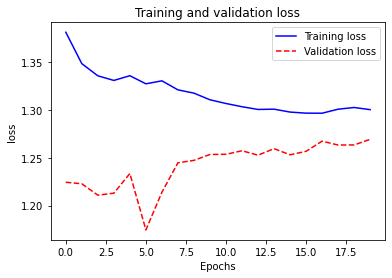

In [16]:
#evaluate
plot_results(history, 'loss')

In [17]:
score = model.evaluate(x_test, y_test)
guesses = model.predict(x_test)
print(f'#Test accuracy:{score[1]:.3f}')
print(confusion_matrix(y_test.argmax(axis=1), guesses.argmax(axis=1),labels=[0,1,2,3]))
print(accuracy_score(y_test.argmax(axis=1), guesses.argmax(axis=1)))

31/31 [==============================] - 0s 6ms/step - loss: 1.2550 - acc: 0.4861
#Test accuracy:0.486
[[328 206  12  48]
 [ 92 129  11  35]
 [ 19  35   5  10]
 [ 11  16   4  10]]
0.486096807415036


In [18]:
guesses.argmax(axis=1)

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 3, 0, 3, 1, 3, 0, 1, 0, 1, 1,
       0, 1, 1, 3, 1, 1, 1, 0, 0, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 3, 0, 2, 1, 1, 0, 3, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       3, 1, 1, 1, 0, 0, 3, 1, 1, 1, 0, 0, 0, 1, 0, 1, 3, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 3, 0, 3, 1, 3, 0, 2, 0, 3, 1, 0, 0,
       3, 3, 1, 3, 0, 1, 0, 1, 1, 1, 1, 0, 0, 3, 1, 3, 1, 0, 0, 0, 1, 3,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 3, 0, 1, 0, 1, 3, 0, 3, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 3, 1, 0, 0, 3, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0,
       0, 0, 3, 1, 1, 1, 0, 0, 3, 0, 0, 1, 1, 3, 0, 3, 0, 0, 1, 1, 1, 3,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 3, 0, 1, 3, 0, 0, 0, 0,
       1, 3, 1, 2, 1, 2, 3, 0, 3, 1, 0, 1, 0, 1, 0,

In [19]:
y_test.argmax(axis=1)

array([0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 3, 2, 0, 0, 0, 1, 3, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 3, 0, 2, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 3, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       3, 3, 1, 3, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 2, 0, 2,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 3, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1,
       1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 1, 3, 0, 0, 3, 2,
       0, 1, 0, 3, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0,